# Using SGD-MICE to train a logistic regression model

The goal of this example is to use SGD-MICE to train a logistic regression model with $\ell_2$ regularization to perform binary classification.
The idea is to use the logistic function,
$$
h(z) = \frac{1}{1 + \exp(-z)},
$$
of an affine transformation of a data point as the probability of it belonging to a class.
Here, a data point $(\boldsymbol{x}_\alpha, y_\alpha)$ is such that $\boldsymbol{x}_\alpha \in \mathbb{R}^{d}$ is a vector of features and $y_\alpha \in \{-1,1\}$ denotes that this data point belongs to a class encoded as $-1$ or $1$.
Then, for a vector of weights $\boldsymbol{w}$,
$$
h(\boldsymbol{w}^\intercal \boldsymbol{x}_\alpha) = \mathbb{P}(y_\alpha = 1 | \boldsymbol{x}_\alpha; \boldsymbol{w}).
$$
We want to find the optimal vector $\boldsymbol{w}$ that better predicts the class of a vector $\boldsymbol{x}_\alpha$.

To measure how well the model with parameter $\boldsymbol{w}$ performs classification, we use the $\ell_2$-regularized log-loss function
$$
F(\boldsymbol{w}) = \frac{1}{N} \sum_{\alpha=1}^N f\left(\boldsymbol{w}, \boldsymbol{\theta}_\alpha= (\boldsymbol{x}_\alpha, y_\alpha)\right) = \frac{1}{N} \sum_{\alpha=1}^N \log(1 + \exp(-y_\alpha \boldsymbol{w}^\intercal \boldsymbol{x}_\alpha))
+ \frac{\lambda}{2} \|\boldsymbol{w}\|^2.
$$

This class of problems is $L$-smooth and strongly-convex, thus, we expect SGD-MICE to converge linearly in this case.

We start by importing NumPy, matplotlib and MICE.

In [ ]:
!pip install mice
import numpy as np
import matplotlib.pyplot as plt
from mice import MICE, plot_mice

We will train the model on synthetic two-dimensional data that allows for visualization of the feature space.
Moreover, we need a set of data for training and another one, independent from the first, for cross-validation.
Both the training and testing sets have 1000 points, 500 for each class.
We assume the feature vectors to be multivariate Gaussian-distributed as

$$
\boldsymbol{X}_1 \sim \mathbb{N}
\left(
\begin{bmatrix}
-3\\
-4
\end{bmatrix}
,
\begin{bmatrix}
        10 & -4 \\
        -4 & 5
\end{bmatrix}
\right)
, \quad
\text{and }
\boldsymbol{X}_{-1} \sim \mathbb{N}
\left(
\begin{bmatrix}
1\\
3
\end{bmatrix}
,
\begin{bmatrix}
        6 & 2 \\
        2 & 5
\end{bmatrix}
\right),
$$
and draw each $\boldsymbol{x}_\alpha$ from its respective distribution depending on $\boldsymbol{y}_\alpha$.

To account for a translation of the decision boundary, we introduce a bias in the model by including a feature equaling one in all generated data.

In [2]:
np.random.seed(0)

datasize = 1000
n_features = 2
reg_param = 1e-3

X_1_mean = np.array([-3, -4])
X_1_cov = np.array([[10, -4], [-4, 5]])
X_1_train = np.random.multivariate_normal(X_1_mean, X_1_cov, int(datasize/2))
X_1_train = np.hstack([X_1_train, np.ones((int(datasize/2), 1))])

X_m1_mean = np.array([1, 3])
X_m1_cov = np.array([[6, 2], [2, 4]])
X_m1_train = np.random.multivariate_normal(X_m1_mean, X_m1_cov, int(datasize/2))
X_m1_train = np.hstack([X_m1_train, np.ones((int(datasize/2), 1))])

Y_1_train = np.ones(int(datasize/2))
Y_m1_train = -1*np.ones(int(datasize/2))

X = np.vstack([X_1_train, X_m1_train])
Y = np.hstack([Y_1_train, Y_m1_train])

train_data = [*zip(X, Y)]
np.random.shuffle(train_data)


X_1_test = np.random.multivariate_normal(X_1_mean, X_1_cov, int(datasize/2))
X_1_test = np.hstack([X_1_test, np.ones((int(datasize/2), 1))])

X_m1_test = np.random.multivariate_normal(X_m1_mean, X_m1_cov, int(datasize/2))
X_m1_test = np.hstack([X_m1_test, np.ones((int(datasize/2), 1))])

Y_1_test = np.ones(int(datasize/2))
Y_m1_test = -1*np.ones(int(datasize/2))

X_test = np.vstack([X_1_test, X_m1_test])
Y_test = np.hstack([Y_1_test, Y_m1_test])

Now that both the training and testing sets are ready, let's define the log-loss function and its gradient.

In [3]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def loss_full(W):
    ls = (np.log(1 + np.exp(-Y * (X @ W)))) + .5*reg_param*(W @ W)
    return np.mean(ls)

def lossgrad_full(W):
    grad = -(sigmoid(-Y * (X @ W))*Y) @ X / datasize + reg_param * W
    return grad

def lossgrad(W, thetas):
    grad = np.zeros((len(thetas), n_features+1))
    for i, theta in enumerate(thetas):
        grad[i] = -sigmoid(-theta[1] * (theta[0] @ W)) * \
            theta[0] * theta[1] + reg_param * W
    return grad

Next, we define functions to measure the accuracy of the model in the testing set.

In [4]:
def accuracy_test(W):
    p_true = sigmoid(X_test @ W)
    p_false = sigmoid(-X_test @ W)
    P = p_true > p_false
    acc = np.mean((P*2-1) == Y_test)
    return acc

Finally, let's define a function to plot the data and the decision boundary of the model.
We will plot one class ($\boldsymbol{y}=1$) in blue and the other ($\boldsymbol{y}=-1$) in brown. 
The background is colored according to the classification of the model.
Moreover, we will plot the training set with black edges and the testing set with white edges.

In [5]:
def plot_data(W):
    fig, ax = plt.subplots(figsize=(6,6), dpi=100)
    ax.scatter(X[:,0], X[:,1], c=Y, edgecolor='k', cmap=plt.cm.Paired)
    ax.scatter(X_test[:,0], X_test[:,1], c=Y_test, edgecolor='w', cmap=plt.cm.Paired)
    x_lims = ax.get_xlim()
    y_lims = ax.get_ylim()
    xs = np.linspace(x_lims[0], x_lims[1], 50)
    ys = np.linspace(y_lims[0], y_lims[1], 50)

    pred = np.zeros((50, 50))
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            pred[j, -i-1] = sigmoid(np.array([x, y, 1]) @ W) < .5

    ax.imshow(pred, extent=[x_lims[0], x_lims[1], y_lims[0], y_lims[1]], cmap=plt.cm.Paired)
    return fig

Now, here we will initialize the weights vector with zeros and check the loss and accuracy of the model with it,

In [6]:
W = np.zeros(shape=(n_features+1))

print(f'loss_full(W)={loss_full(W)}')
print(f'accuracy_test(W)={accuracy_test(W)}')

loss_full(W)=0.6931471805599454
accuracy_test(W)=0.5


and plot the data with the decision boundary for the model with the starting weights.

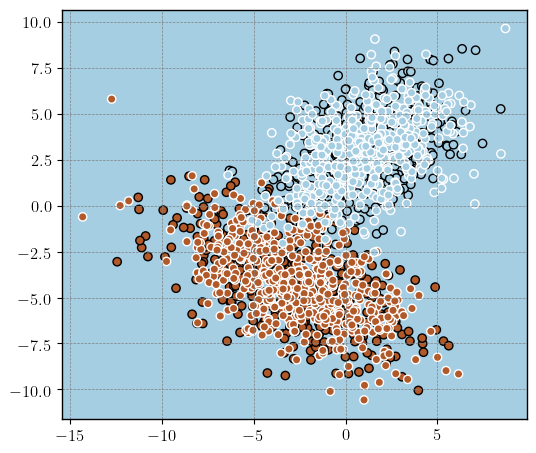

In [7]:
fig = plot_data(W)

It is clear that, with this choice of initializing the weights with zeros, the model predicts blue ($\boldsymbol{y}=1$) for all the data points in both the training and testing sets.

To train the model using SGD-MICE with the optimal step-size, we need to know the $L$-smoothness constant of the loss function. Moreover, we also set $\epsilon$, the tolerance on the statistical error of the gradient estimates, a parameter of MICE.

In [8]:
L = 0.25 * np.mean((X**2).sum(axis=1)) + reg_param

print(f'L={L}')

eps = 0.5

step_size = 2/(L+reg_param)/(1+eps**2)
print(f'step_size = {step_size}')


L=7.58716208768028
step_size = 0.2108547473699424


Finally, we create an instance of the MICE class with the gradient of the log-loss function, the list with the training data, the tolerance on the statistical error $\epsilon$, the maximum number of gradient evaluations (here set as 10 epochs), and the minimum batch size,

In [9]:
df = MICE(lossgrad, 
          sampler=train_data,
          eps=eps, 
          max_cost=10*datasize, 
          min_batch=5)

and perform optimization until df.terminate returns True.

In [10]:
losses = [loss_full(W)]
accuracies = [accuracy_test(W)]
while True:
    grad = df(W)
    if df.terminate:
        break
    W = W - step_size*grad
    losses.append(loss_full(W))
    accuracies.append(accuracy_test(W))
print(W)

[-0.57690229 -1.58362153 -1.81459809]


In [11]:
print(f'Starting loss: {losses[0]}')
print(f'Final loss: {losses[-1]}')

Starting loss: 0.6931471805599454
Final loss: 0.06614685480157584


In [12]:
print(f'Starting accuracy: {accuracies[0]}')
print(f'Final accuracy: {accuracies[-1]}')

Starting accuracy: 0.5
Final accuracy: 0.978


Training the logistic regression model greatly improved its accuracy in comparison with the starting guess, as can also be observed in the next Figure.

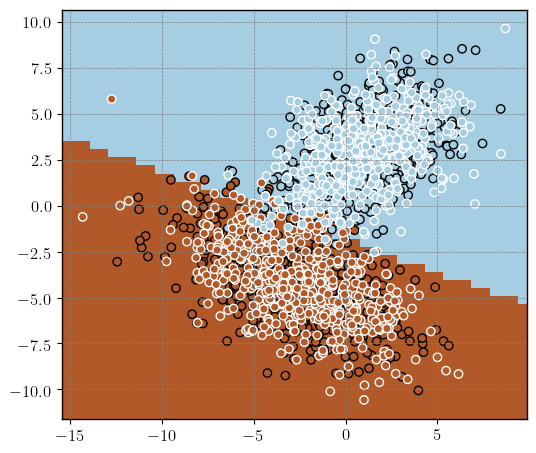

In [13]:
fig = plot_data(W)

Information with respect to MICE for all iterations is available in df.log.
This log is a pandas DataFrame and can be given as input to the plot_mice function.
For this reason, we will add information that we computed (loss function values and accuracies) in this DataFrame to plot them later.

In [14]:
log = df.get_log()
log['loss'] = losses
log['accuracy'] = accuracies
log

event  num_grads            vl  bias_rel_err  grad_norm  iteration  \
0      start         50  4.344155e+00      0.000000   2.214302        1.0   
1    restart        110  3.036002e-01      0.000000   0.451342        2.0   
2    dropped        120  1.011007e-02      0.221457   0.335490        3.0   
3    dropped        140  3.175136e-02      0.255864   0.290376        4.0   
4    dropped        170  3.701133e-02      0.326740   0.227388        5.0   
..       ...        ...           ...           ...        ...        ...   
370     MICE       9943  4.508993e-09      1.255374   0.016609      371.0   
371  dropped       9963  2.860285e-09      1.255900   0.016602      372.0   
372  dropped       9983  3.491157e-09      1.257066   0.016586      373.0   
373     MICE      10003  7.686893e-07      1.264142   0.016494      374.0   
374      end      10003           NaN           NaN        NaN        NaN   

     hier_length      loss  accuracy  
0            1.0  0.693147     0.500  
1            1.0  0.213022     0.946  
2            2.0  0.181227     0.946  
3            2.0  0.163661     0.946  
4            2.0  0.151987     0.946  
..           ...       ...       ...  
370         61.0  0.066216     0.978  
371         62.0  0.066198     0.978  
372         62.0  0.066181     0.978  
373         62.0  0.066163     0.978  
374          NaN  0.066147     0.978  

[375 rows x 9 columns]

And, finally, let's generate Figures with the loss function value, accuracy, and gradient estimate norm versus the number of gradient evaluations.

Text(0.5, 0, 'Number of gradient evaluations')

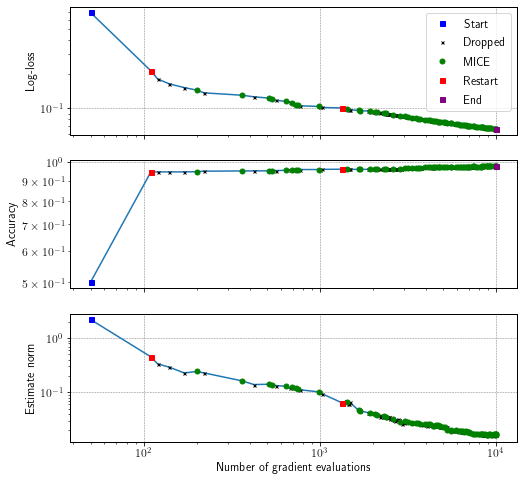

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
axs[0] = plot_mice(log, axs[0], x='num_grads', y='loss', legend=True)
axs[0].set_ylabel('Log-loss')
axs[1] = plot_mice(log, axs[1], x='num_grads', y='accuracy', legend=False)
axs[1].set_ylabel('Accuracy')
axs[2] = plot_mice(log, axs[2], x='num_grads', y='grad_norm', legend=False)
axs[2].set_ylabel('Estimate norm')
axs[2].set_xlabel('Number of gradient evaluations')

And now, the exact same quantities versus iterations.

Text(0.5, 0, 'Iterations')

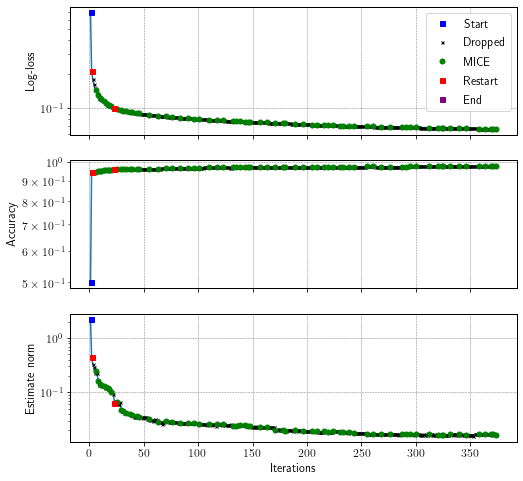

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
axs[0] = plot_mice(log, axs[0], x='iteration', y='loss', style='semilogy', legend=True)
axs[0].set_ylabel('Log-loss')
axs[1] = plot_mice(log, axs[1], x='iteration', y='accuracy', style='semilogy',legend=False)
axs[1].set_ylabel('Accuracy')
axs[2] = plot_mice(log, axs[2], x='iteration', y='grad_norm', style='semilogy',legend=False)
axs[2].set_ylabel('Estimate norm')
axs[2].set_xlabel('Iterations')